# COGS 108 - Final Project 

# Overview

This project explores several factors as potential predictors of park ratings and review counts in San Diego as shown on Yelp. Specifically, I tested the validity of the area of the park and the proportions of ethnic and racial minorities in the neighborhood as predictors. The result shows that park size is positively correlated with rating and the number of reviews. However, the proportion of the Black population is not a strong predictor of the average park rating and review count in the region (by ZIP code), while the proportion of the Hispanic population is a significant negative predictor of the average number of reviews in the region.

# Name & GitHub

- Name: Yufei Deng
- GitHub Username: Yukodeng

# Research Question

Do park rating and review count increase with park size? Does it decrease with a higher percentage of ethnic minority population in the neighborhood?

## Background and Prior Work

As San Diego County becomes more diverse in its social make-up, creating spaces for everyone's liking can be a difficult task. Factors driving visitation may include geographic proximity to transportation (accessibility), park features (size, green space, water bodies), and the variety of activities (e.g. natural scenes, sports grounds, themed events, etc.). Together, these characteristics contribute to the popularity of parks in San Diego. For example, Balboa Park is among the most visited place in San Diego, drawing visitors of different age to its natural landscapes and historical architectures. Although not all spaces could be as well-planned and funded, knowing what factors appeals to visitors can help optimize park planning and improve residents' lives.

I am interested in studying factors that underly park popularity. A similar question was asked by Hamstead et al. (2018)[1], who researched on parks in New York City. They extracted data from geo-located social media (GSM)--Flickr and Twitter--as indicators of visitation rates to the 2143 parks across NYC. Then, using regression models, they tests the three potential predictors of visitation rate: 1). Park facilities and characteristics; 2). Accessibility; 3). Neighborhood socio-demographic characteristics. The study found that, indeed, visitation increases with proximity to public transportation, water bodies, and athletic fields. However, it is negatively associated with a higher proportion of ethnic minorities in the neighborhood. The latter part of the finding contrast with results of some of the past studies. It motivates me to also look at the relation between park ratings and the percentage of racial minorities in the neighborhood.

The finding has many implications. The study Liu et al. (2015)[2] integrated a model that categorize factors influencing park visit to three levels: intrapersonal (psychological factors); interpersonal (interactions dependent on others); and structural (environmental factors such as the proximity of facilities). The fact that proportion of ethnic minorities population is negatively associated with park visitation rates can be attributed to neighborhood socio-economic factors, which is environmental, or it can be accounted for by psychological variations between racial and ethnic groups. In fact, studies have found that older adults, racial or ethnic minorities, females, and lower-income families were more likely to be infrequent or nonusers of park. This means that park visitation patterns vary between individuals across age, ethnicity, income, education, personality, etc. 

My final research will be a preliminary exploration on the gorund of these studies. Instead of using answers from questionnaires or soical media that indicate park visitation, I use park ratings and the number of reviews on Yelp as indicators of park popularity. I chose park size and neighborhood racial and ethnic group population percentage as two potential predictors of park popularity. These studies provide me ideas to analyze data and interpret my findings. 


References:
- 1) Geolocated social media as a rapid indicator of park visitation and equitable park access. https://doi.org/10.1016/j.compenvurbsys.2018.01.007
- 2) The impact of socio-demographic, environmental, and individual factors on urban park visitation in Beijing, China. https://doi.org/10.1016/j.landurbplan.2018.08.004

# Hypothesis


There are relations between park ratings & number of reviews and __1). park area__ and __2).population percentages of ethic groups in the neighborhood__. Yelp rating and review count increase with park size, decrease with Black & Hispanic population percentages, and increase with White population percentages.

# Datasets


__1. San Diego Parks Yelp Data__ 

- Link to the dataset: https://www.yelp.com/developers/documentation/v3/business_search
- Number of observations: 833
- Description: Park ratings, number of reviews, address, and other park information. 
    - The variables I will be using include: __Park name, park address, park rating, total review count__.

- Park rating and review count will be used as the outcome of prediction, which will be analyzed separately. Although, ideally, I want only one variable as the popularity index, such as the visitation rate. The rating values are discrete, therefore not ideal for analysis.

__2. Park Locations Data__
- Link to the dataset: https://data.sandiego.gov/datasets/park-locations/
- Number of observations: 2769
- Description: Geojson file. Includes geo-information and areas (in acres) of parks in San Diego.
    - The variables I will be using: __Park (full) name, park area (in acres)__.

- I will combine it with the Yelp dataset to analyze the relation between area and rating/ review count. It has more observations, thus leaving some room for dropping missing or unsuitable values.

__3. San Diego Regional Population by Race__
- Link to the dataset: https://github.com/Yukodeng/individual_fa20/raw/master/data/censusacs_2010_zip_all_2020_12_13%2006_17.xlsx
- Number of observations: 860
- The variables I will be using: __ZIP, Racial and ethnic categories, population by race and ethnicity__.

- This is the 2010 Census data. San Diego might have undergone population changes. Thus, I will address this limitation in the discussion.

# Setup

In [1]:
%matplotlib inline

# essentials
import numpy as np
import pandas as pd
import geopandas as gpd

# graphics
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10, 5)
import seaborn as sns
sns.set_theme(style="ticks",font_scale=1.3)

# statistical tools
import patsy
import scipy.stats as stats
import statsmodels.api as sm

%config InlineBackend.figure_format ='retina'

# Data Cleaning

## Park Areas and Yelp Ratings

In [2]:
# Load datasets
yelp_SD = pd.read_csv('../data/yelp_SD_parks.csv')
park_df = gpd.read_file('../data/parks_datasd.geojson')

## Check out the columns
print(yelp_SD.columns)
print(park_df.columns)

Index(['name', 'address', 'phone', 'id', 'url', 'rating', 'review_count',
       'longitude', 'latitude', 'is_closed'],
      dtype='object')
Index(['objectid', 'name', 'alias', 'gis_acres', 'park_type', 'location',
       'owner', 'geometry'],
      dtype='object')


In [3]:
park_df[['name','alias']].head()

,name,alias
0,South Carlsbad SB,South Carlsbad State Beach
1,Torrey Pines SB,Torrey Pines State Beach
2,Ruocco Park,Ruocco Park
3,Tuna Harbor Park,Tuna Harbor Park
4,San Diego Bayfront Park,San Diego Bayfront Park


The values in "name" turn out to be the abbreviated names. For the advantage of merging with yelp dataset later, I will drop it and use `"alias"` instead.

In [4]:
# Drop columns
yelp_SD = yelp_SD.drop(columns=['phone','id','url','longitude','latitude','is_closed'])
park_df = park_df.drop(columns=['objectid','name','location','park_type','owner','geometry'])

# Rename columns
park_df = park_df.rename(columns={'alias':'name', 'gis_acres':'acres'})

In [5]:
# Check for missing values
print(yelp_SD.isna().sum())
print(park_df.isna().sum())

name            0
address         0
rating          0
review_count    0
dtype: int64
name     0
acres    0
dtype: int64


Now the "yelp" dataset has variables:
- `name`
- `address`
- `rating`
- `review_count`

The "Park" datasets variables:
- `name`
- `acres`

Both have no missing values. It's ready to merge the two datasets by "name".

In [6]:
# merge park rating and park area
df = pd.merge(yelp_SD, park_df, on='name')

df = df.sort_values(by=('review_count'), ascending=False)
# Check out the merged dataset
df.head()

,name,address,rating,review_count,acres
0,Balboa Park,"1549 El Prado San Diego, CA 92101",5.0,2105,1089.476460
23,Torrey Pines State Reserve,"12600 N Torrey Pines Rd La Jolla, CA 92037",4.5,1319,198.780945
7,Sunset Cliffs Natural Park,"1253 Sunset Cliffs Blvd San Diego, CA 92107",5.0,935,67.109374
25,Cabrillo National Monument,"1800 Cabrillo Memorial Dr San Diego, CA 92106",4.5,681,153.276913
80,Mission Trails Regional Park,"1 Father Junipero Serra Trl San Diego, CA 92119",4.5,360,451.537474


The data look pretty clean till this point. However, we still don't know how values in each column are distributed and whether the distributions are normal. This I will test later.

## Population by Race Data

In [7]:
# Load data
demog_df = pd.read_excel('https://github.com/Yukodeng/individual_fa20/raw/master/data/censusacs_2010_zip_all_2020_12_13%2006_17.xlsx')

In [8]:
# Check out the columns
demog_df.columns

Index(['Zip', 'YEAR', 'RACE', 'NUMBER'], dtype='object')

In [9]:
# Drop and rename colummns
demog_df = demog_df.drop(columns=['YEAR'])
demog_df = demog_df.rename(columns={'Zip':'zipcode','RACE':'race','NUMBER':'number'})

# Check if values are standardized
demog_df['race'].unique()

array(['Pacific Islander', 'White', 'Black', 'Other', 'Two or More',
       'American Indian', 'Hispanic', 'Asian'], dtype=object)

### Calculating Percentages of Black, Hispanic, and White Population for Each ZIP

In [10]:
# Selecting rows with the three racial categories
race_pop = demog_df.loc[(demog_df['race']=='Black')|
                        (demog_df['race']=='Hispanic')|
                        (demog_df['race']=='White')]

race = race_pop.groupby(['zipcode','race']).sum()

# Transform values in "number" into percentages of total population
racegrouped = race.groupby(level=0).apply(lambda g: g / g.sum()).reset_index()
racegrouped.head()

,zipcode,race,number
0,91901,Black,0.012566
1,91901,Hispanic,0.166490
2,91901,White,0.820944
3,91902,Black,0.040060
4,91902,Hispanic,0.491033


In [11]:
# Selection by raical category and put into Series
AfriAm_perc = racegrouped.loc[racegrouped['race']=='Black',['zipcode','number']]
Hisp_perc = racegrouped.loc[racegrouped['race']=='Hispanic',['zipcode','number']]
White_perc =  racegrouped.loc[racegrouped['race']=='White',['zipcode','number']]

print(AfriAm_perc.shape,Hisp_perc.shape, White_perc.shape)

(110, 2) (110, 2) (111, 2)


### New Data Frame with Percentages

In [12]:
# New dataframe with variable--total population by ZIP code
demogDF = demog_df.groupby('zipcode')['number'].agg([np.sum]).reset_index(level=0)

# Merging Series into the new dataframe
demogDF = pd.merge(demogDF, AfriAm_perc, on='zipcode')
demogDF = pd.merge(demogDF, Hisp_perc, on='zipcode')
demogDF = pd.merge(demogDF, White_perc, on='zipcode')

demogDF = demogDF.rename(columns={'sum':"total_pop",'number_x':'Black',
                        'number_y':'Hispanic','number':'White'})

# Is zipcode of str type?
demogDF.dtypes

zipcode        int64
total_pop      int64
Black        float64
Hispanic     float64
White        float64
dtype: object

In [13]:
# Transform zipcode into str type
demogDF['zipcode'] = demogDF['zipcode'].astype(np.str)

In [14]:
# Check out the dataset
demogDF.head()

,zipcode,total_pop,Black,Hispanic,White
0,91901,17084,0.012566,0.166490,0.820944
1,91902,17005,0.040060,0.491033,0.468907
2,91905,1669,0.034975,0.274804,0.690221
3,91906,5765,0.068387,0.387834,0.543779
4,91910,76153,0.044212,0.682264,0.273524


# Data Analysis and Results

## Exploratory Data Analysis

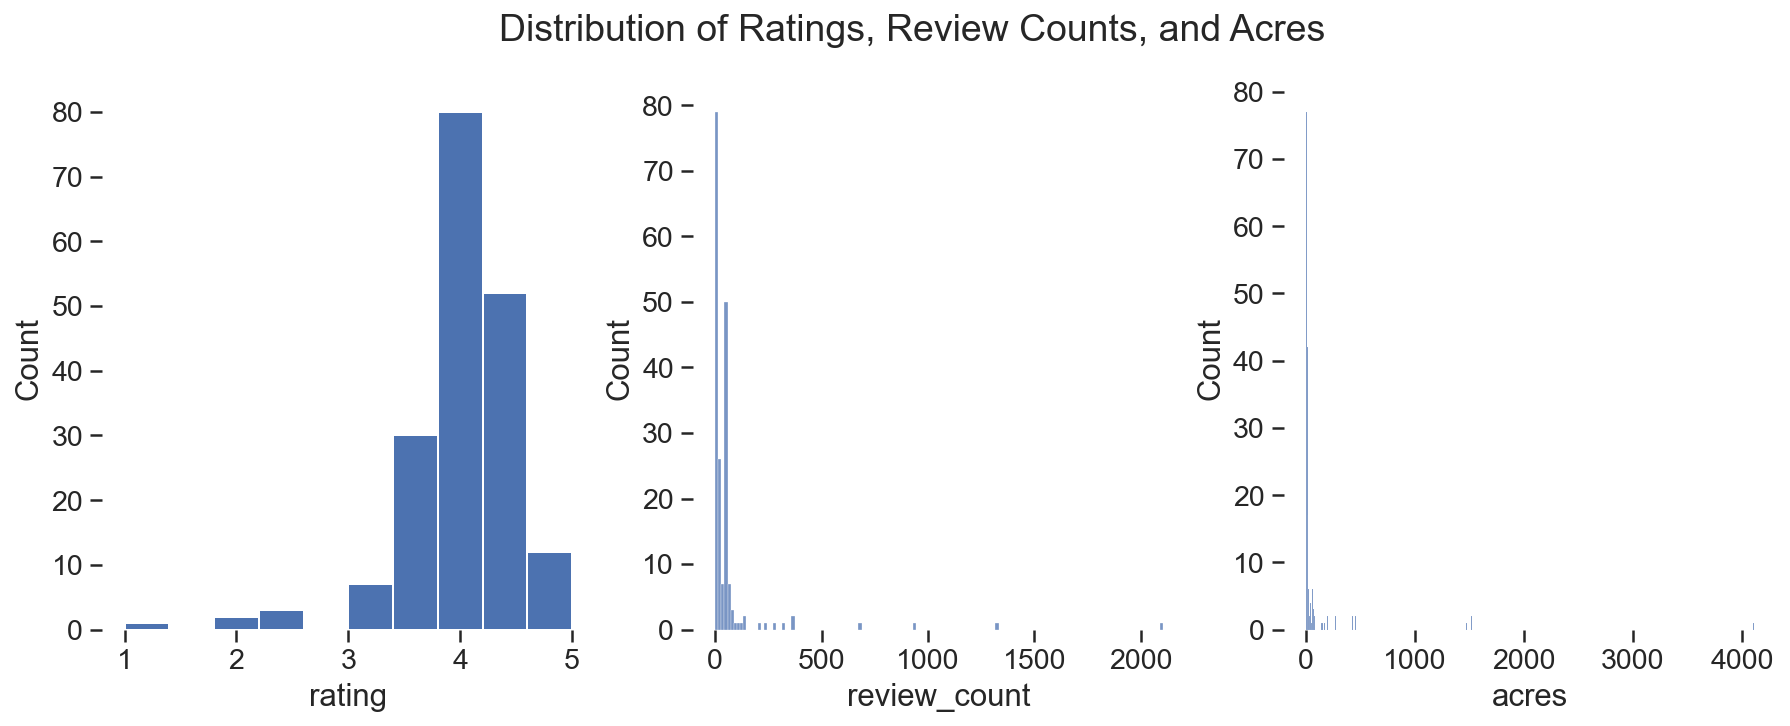

In [15]:
# Plot the rating, review_count, acres distributions
## to check for outliers
f, axes = plt.subplots(1,3,figsize=(15,5))
f.suptitle('Distribution of Ratings, Review Counts, and Acres')
axes[0].hist(df['rating'])
axes[0].set_xlabel('rating')
axes[0].set_ylabel('Count')
sns.histplot(df['review_count'], ax=axes[1])
sns.histplot(df['acres'], ax=axes[2])

sns.despine(f,left=True,bottom=True)

Notice that the two distributions on the right are extremely right-skewed. For the advantage of fitting the Ordinary Least Square Regression model, we need to tranform the data to resemble normal distributions. I will use log transformation on `review_count` and `acres` to reduce right-skewness. Because `rating` is left-skewed and discrete, I decide to use cube transformation on rating (x^3).

In [16]:
# Log/ Cube root transform values
df['rating3'] = np.power(df['rating'],3)
df['review_count10'] = np.log10(df['review_count'])
df['acres10'] = np.log10(df['acres'])

### Testing Distributions of Rating, Review Count, and Area for Normality

In [17]:
h_rate = df['rating3'].values
h_rev = df['review_count10'].values
h_ac = df['acres10'].values

st_rate, p_rate = stats.normaltest(h_rate)
st_rev, p_rev = stats.normaltest(h_rev)
st_ac, p_ac = stats.normaltest(h_ac)

# Print p-values of normality tests
print('p for rating is:',p_rate)
print('p for review count10 is:',p_rev)
print('p for acres10 is:',p_ac)

p for rating is: 0.5601476168442974
p for review count10 is: 0.22402515869717077
p for acres10 is: 3.603567813310103e-05


The `p-values` for the log transformed distributions are greater than 0.01 (alpha=0.01), therefore rejecting the null in favor of the alternative hyphothesis, suggesting normality. Therefore, we are able to fit OLS regression models to the data.

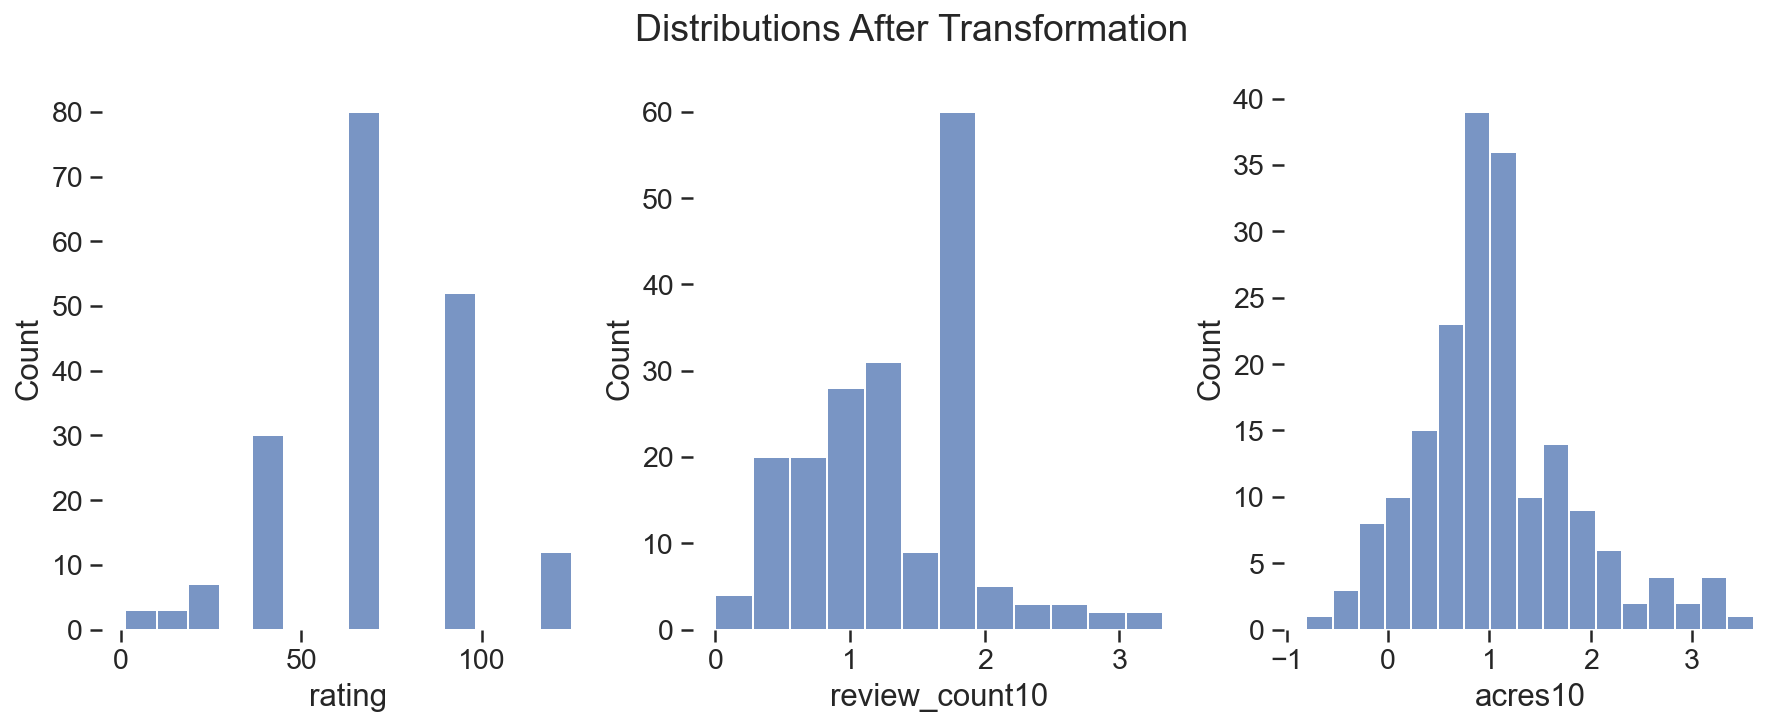

In [18]:
# Check out the new distributions
f, axes = plt.subplots(1,3,figsize=(15,5))
f.suptitle('Distributions After Transformation')

axes[0].hist(df['rating'])
axes[0].set_xlabel('rating')
axes[0].set_ylabel('Count')

sns.histplot(df['rating3'], ax=axes[0])
sns.histplot(df['review_count10'], ax=axes[1])
sns.histplot(df['acres10'], ax=axes[2])
sns.despine(f, left=True, bottom=True)

## Fitting a Regression Model to Predict Review Counts

In [19]:
# Fit OLS Regression model
outcomeRev, predictorsAcr = patsy.dmatrices('review_count10 ~ acres10', df)
mod1 = sm.OLS(outcomeRev, predictorsAcr).fit()
print(mod1.summary())

                            OLS Regression Results                            
Dep. Variable:         review_count10   R-squared:                       0.157
Model:                            OLS   Adj. R-squared:                  0.152
Method:                 Least Squares   F-statistic:                     34.41
Date:                Wed, 16 Dec 2020   Prob (F-statistic):           2.02e-08
Time:                        18:11:52   Log-Likelihood:                -158.79
No. Observations:                 187   AIC:                             321.6
Df Residuals:                     185   BIC:                             328.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9513      0.070     13.571      0.0

Text(0, 0.5, 'Review Count')

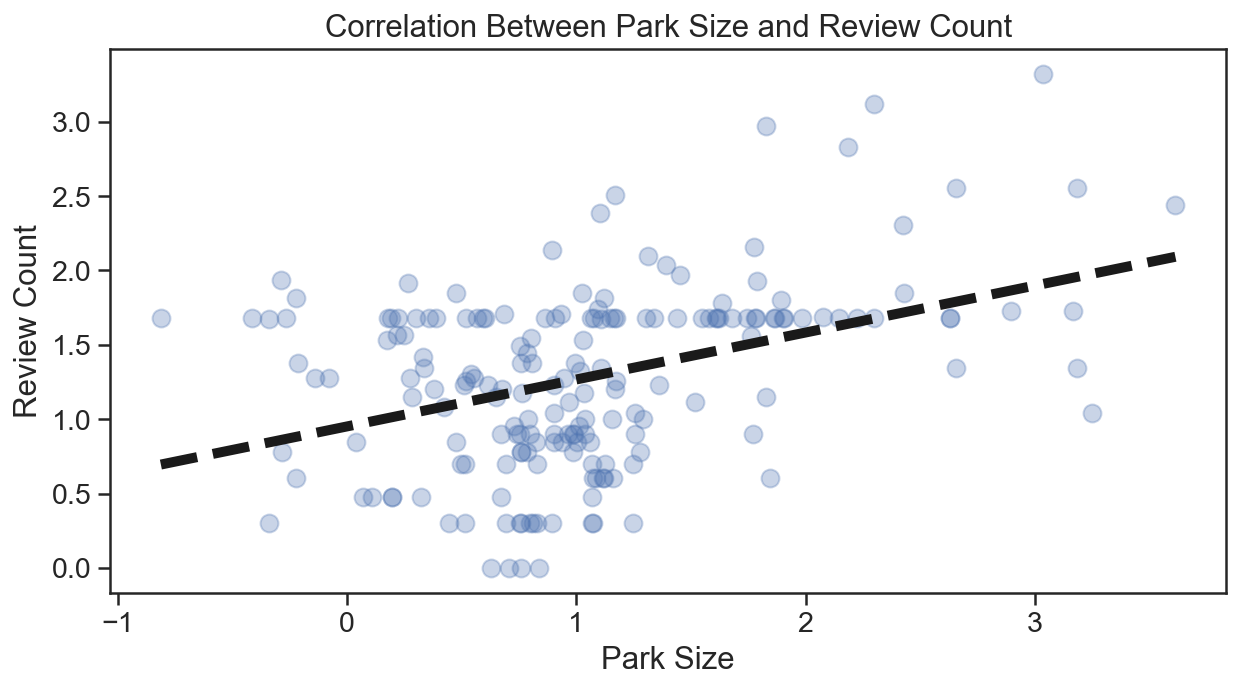

In [20]:
# Plot part area in acres vs number of reviews
plt.scatter(x=df['acres10'], y=df['review_count10'], s=80,alpha=0.3)
xs = np.array([df['acres10'].min(), df['acres10'].max()])
ys = 0.9513 + 0.3157* xs
plt.plot(xs, ys, '--k', linewidth=5)

plt.title('Correlation Between Park Size and Review Count')
plt.xlabel('Park Size')
plt.ylabel('Review Count')

P value is 0.00 (less then alpha 0.01), which successfully rejects the null hypothesis and favors the alternative that there is a significant correlation between park size and number of reviews. The `R^2` is 0.157, which means that `15.7%` of the variation in review count is explained by park size. 

In [21]:
# OLS Regression model to predict rating from park size
outcomeRate, predictorsAcr = patsy.dmatrices('rating3 ~ acres10', df)
mod2 = sm.OLS(outcomeRate, predictorsAcr).fit()
print(mod2.summary())

                            OLS Regression Results                            
Dep. Variable:                rating3   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     3.405
Date:                Wed, 16 Dec 2020   Prob (F-statistic):             0.0666
Time:                        18:11:53   Log-Likelihood:                -866.88
No. Observations:                 187   AIC:                             1738.
Df Residuals:                     185   BIC:                             1744.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     64.3786      3.092     20.823      0.0

Text(0, 0.5, 'Cube Rating')

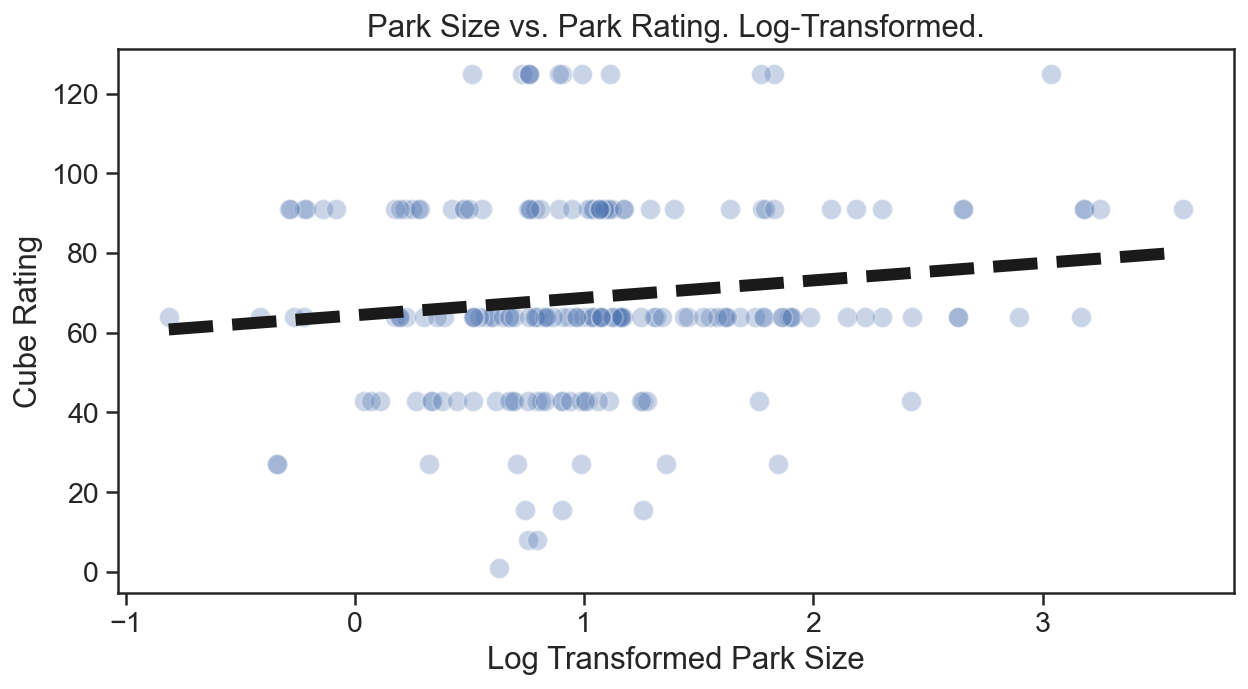

In [22]:
# Plot with regression line
sns.scatterplot(x='acres10',y='rating3', data=df, s=100, alpha=0.3)
xs = np.array([df['acres10'].min(), df['acres10'].max()])
ys = 64.3786 + 4.3794 * xs
plt.plot(xs, ys, '--k', linewidth=6)

plt.title('Park Size vs. Park Rating. Log-Transformed.')
plt.xlabel('Log Transformed Park Size')
plt.ylabel('Cube Rating')

The p value, 0.67, is greater than alpha=0.01, thus fails to reject the null hyphothesis that there is not a significant correlation between park size and park rating. R^2 is 0.018, which also suggests a very weak relashionship.

##  Exploring the Relation Between Racial Population Percentages and Park Reviews

In [23]:
yelp_SD.head()

,name,address,rating,review_count
0,Balboa Park,"1549 El Prado San Diego, CA 92101",5.0,2105
1,Civita Park,"7960 Civita Blvd San Diego, CA 92108",4.5,46
2,Waterfront Park,"1600 Pacific Hwy San Diego, CA 92101",4.5,242
3,Trolley Barn Park,"Adams Ave And Florida St San Diego, CA 92116",4.5,102
4,Bay View Park,"413 1st St Coronado, CA 92118",5.0,42


In [24]:
# Define a function to transform address to zipcode
def address_to_zip(string):
    zip = []
    for str in string:
        if str[-5] == '9':
            # slice out the zipcode 
            zip.append(str[-5:]) 
        else:
            zip.append(np.nan)          
    return zip
# Apply function and drop NaN values
yelp_SD['zipcode'] = address_to_zip(yelp_SD['address'])
yelp_SD = yelp_SD.dropna()

# Check out zipcode values
yelp_SD['zipcode'].unique()

array(['92101', '92108', '92116', '92118', '92123', '92110', '92109',
       '92117', '92111', '92130', '92107', '92129', '92131', '92119',
       '92120', '92106', '92104', '92037', '92127', '92124', '92126',
       '92122', '92075', '92103', '92182', '92102', '92078', '91942',
       '91915', '92624', '92071', '92029', '92064', '92074', '92021',
       '92024', '91932', '92136', '92139', '92040', '91945', '91977',
       '91902', '92026', '92121', '92115', '92105', '92113', '91910',
       '92707', '92171', '92114', '91010', '91950', '92014', '90717',
       '92011', '92065', '92058', '92033', '91941', '92154', '92039',
       '92093', '92166', '92007', '92173', '92025', '90815', '92083',
       '92084', '92008', '92879', '92054', '92020', '92627', '92649',
       '91302', '92132', '91913', '92321', '90069', '92128', '92172',
       '91914', '92835', '92661', '91911', '92626', '92027', '90670',
       '92630', '92145', '92135', '92009', '92038', '92057', '92023',
       '91916', '920

### New Data Frame of Average Rating & Review Count, and Demographic Info

In [25]:
# Calculating the mean rating & review count by zipcode
yelp_df = yelp_SD.groupby('zipcode').mean().reset_index()

In [26]:
# Create the dataframe with all variables needed
df2 = pd.merge(yelp_df, demogDF, on='zipcode')
# Get a gist of df2
df2.describe()

,rating,review_count,total_pop,Black,Hispanic,White
count,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000
mean,3.933041,104.186868,36687.012987,0.055261,0.334552,0.610187
std,0.651499,146.115439,19229.143470,0.055689,0.219439,0.243023
min,1.000000,1.000000,2006.000000,0.004034,0.056037,0.029375
25%,3.764706,24.000000,23406.000000,0.017374,0.156850,0.440047
50%,4.000000,53.500000,37082.000000,0.037054,0.244738,0.687290
75%,4.250000,116.272727,49716.000000,0.070186,0.491033,0.807183
max,5.000000,809.074074,83249.000000,0.311248,0.957433,0.937837


### Data Transforming and Testing Distributions for Normality

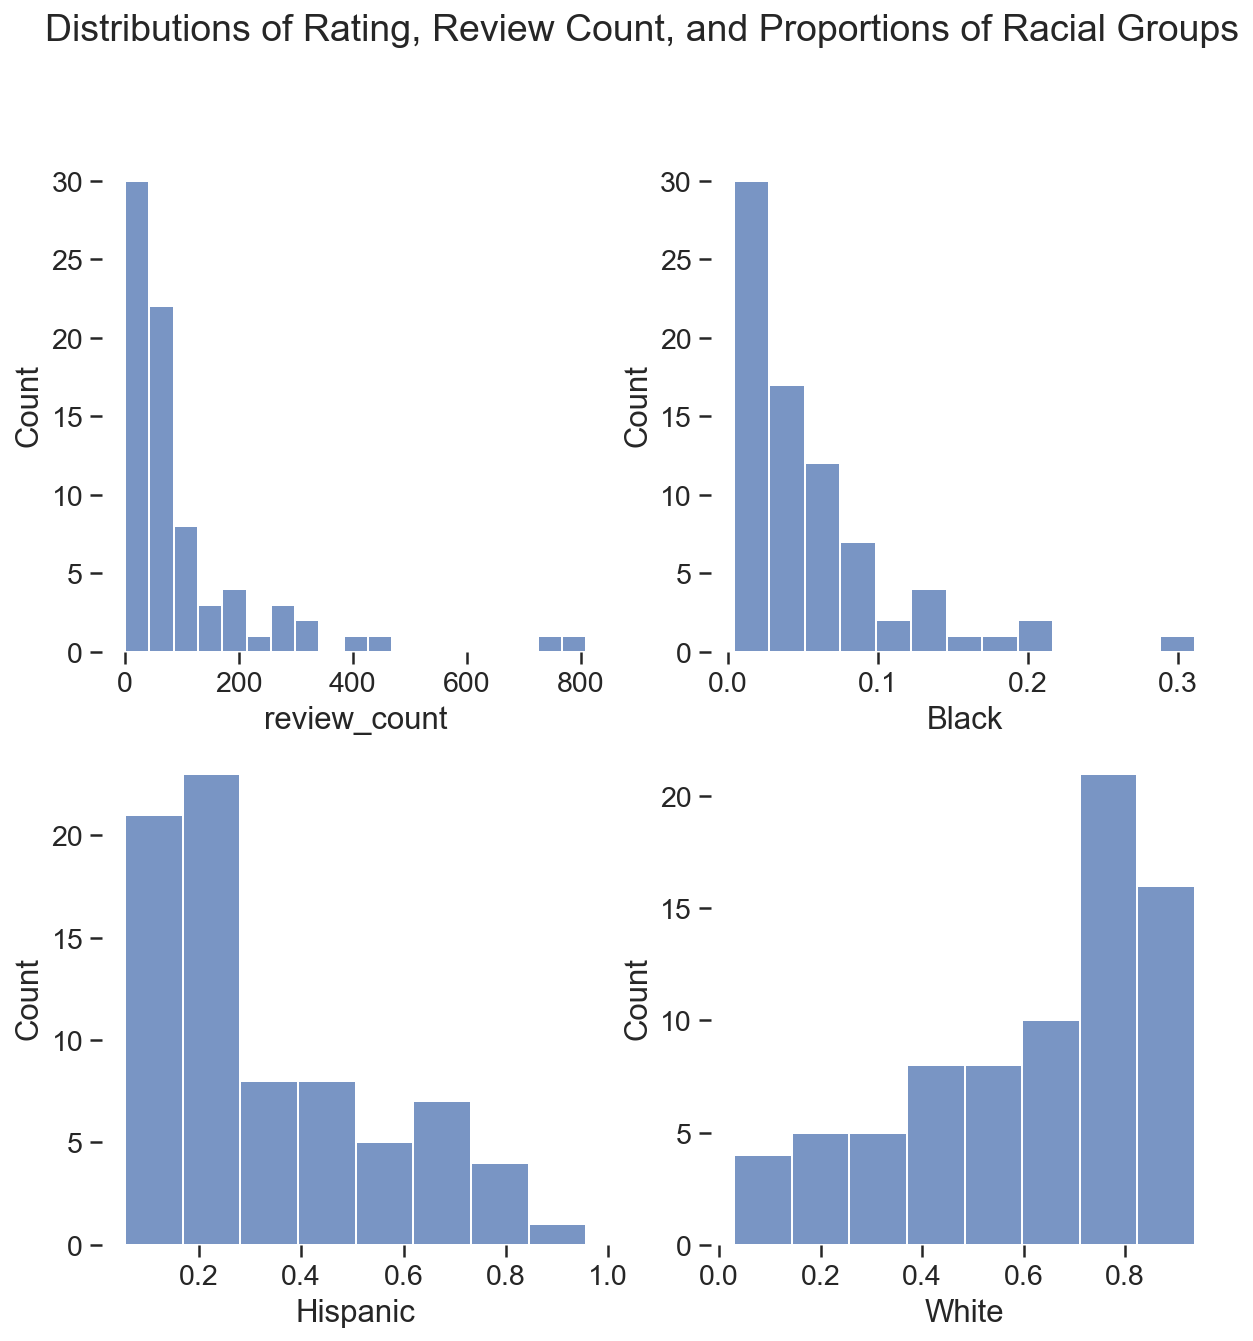

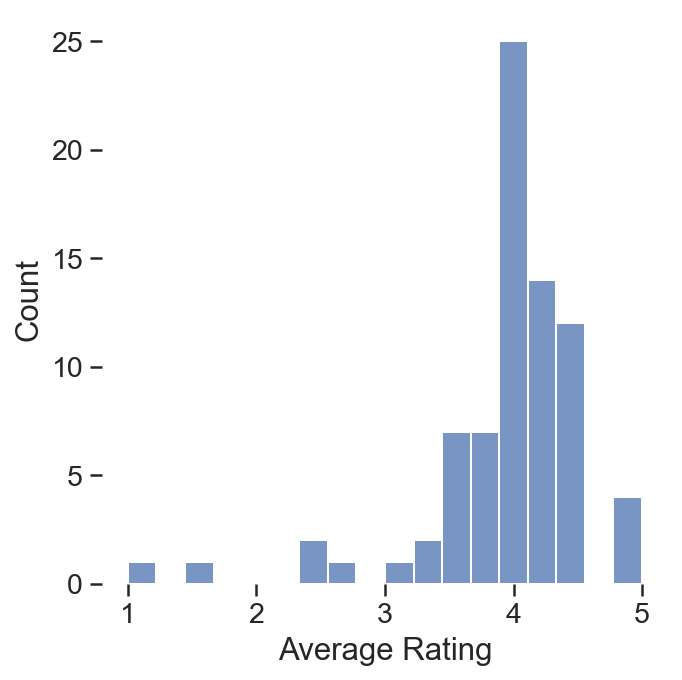

<Figure size 288x288 with 0 Axes>

In [27]:
# Plot the distributions
f, axes = plt.subplots(2, 2, figsize=(10,10))
f.suptitle('Distributions of Rating, Review Count, and Proportions of Racial Groups')
sns.histplot(df2['review_count'],ax=axes[0,0])
sns.histplot(df2['Black'], ax=axes[0,1])
sns.histplot(df2['Hispanic'],ax=axes[1,0])
sns.histplot(df2['White'],ax=axes[1,1])
sns.despine(bottom=True,left=True)

ax = sns.displot(x=df2['rating'])
ax.set(xlabel='Average Rating')
plt.figure(figsize=(4,4))
ax.despine(left=True, bottom=True)

Similarly, I will use the cube of `rating` for analysis. I will log-transform `review_count`, `Black`, and `Hispanic`. Finally, because the distribution of `White` is left-skewed, I decide to reverse it using "1 - x", where x is the values in "White", and then carry out a log transformation. 

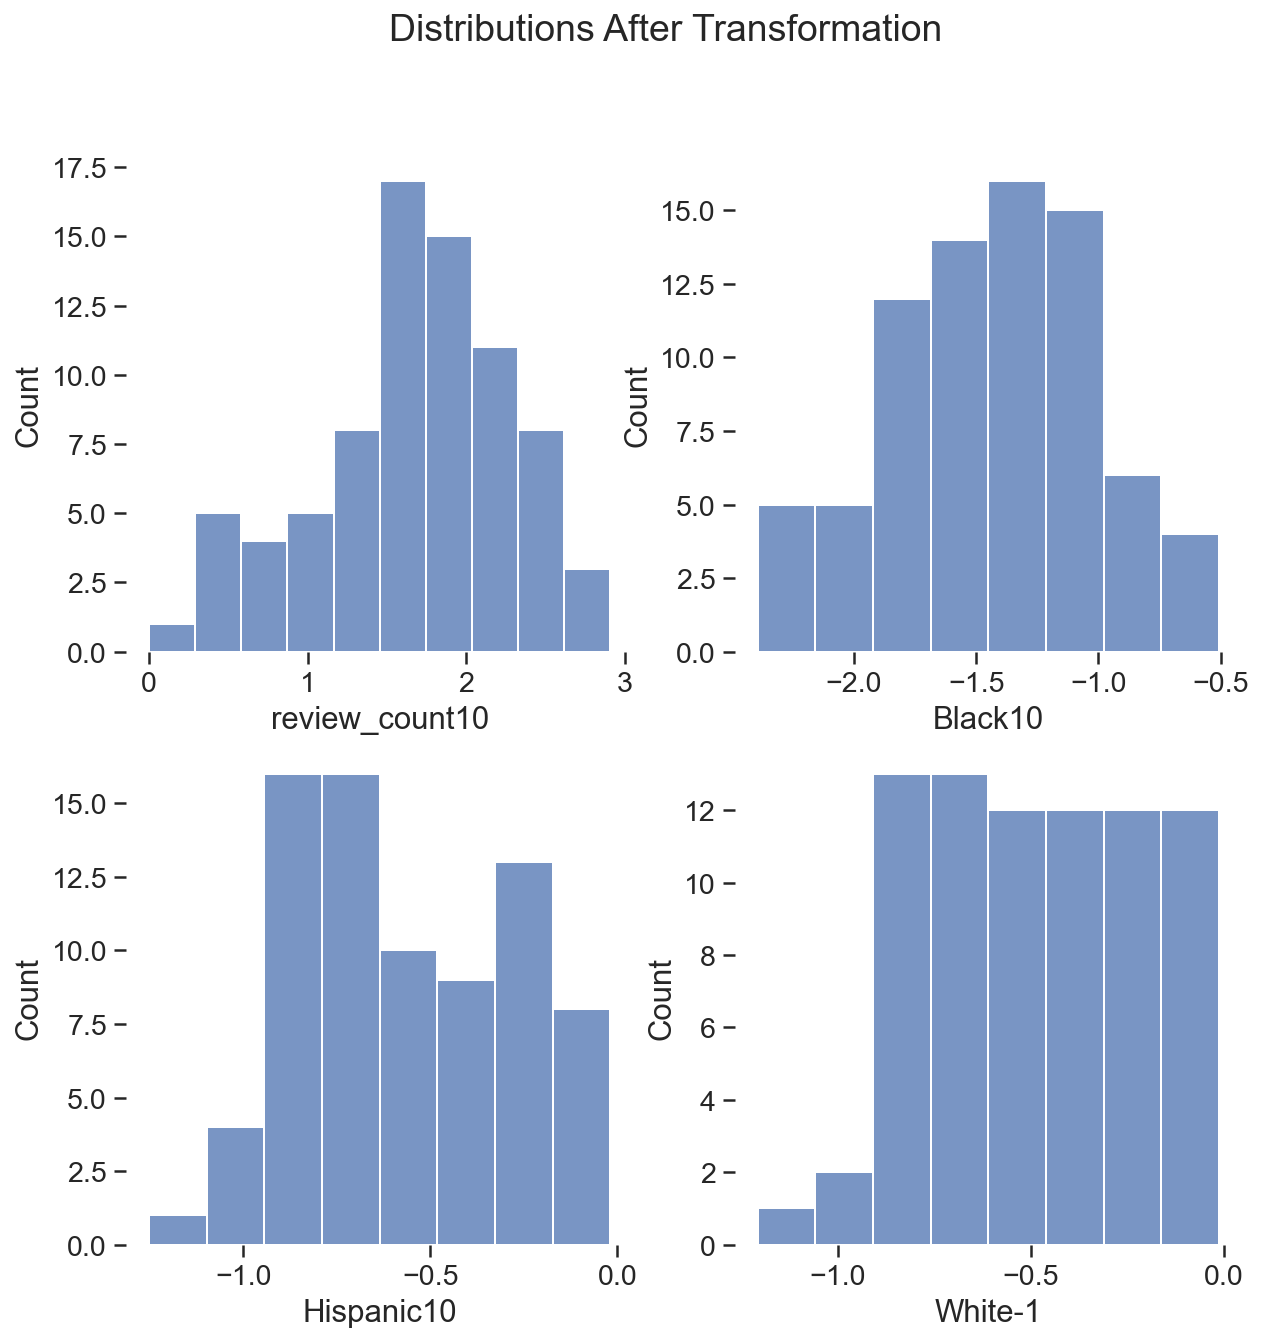

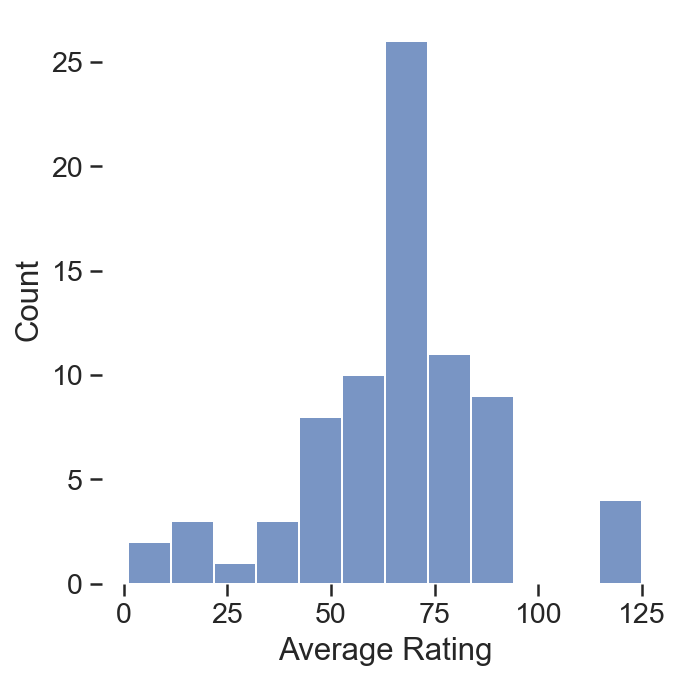

<Figure size 288x288 with 0 Axes>

In [28]:
# Data transformation
df2['rating3'] = np.power(df2['rating'], 3)
df2['review_count10'] = np.log10(df2['review_count'])
df2['Black10'] = np.log10(df2['Black'])
df2['Hispanic10'] = np.log10(df2['Hispanic'])
df2['White-1'] = np.log10(df2['White'].apply(lambda x: 1-x))

# See distributions of transformed data
f, axes = plt.subplots(2,2, figsize=(10,10))
f.suptitle('Distributions After Transformation')

sns.histplot(df2['review_count10'], ax=axes[0,0])
sns.histplot(df2['Black10'], ax=axes[0,1])
sns.histplot(df2['Hispanic10'], ax=axes[1,0])
sns.histplot(df2['White-1'], ax=axes[1,1])
sns.despine(left=True,bottom=True)

ax = sns.displot(x=df2['rating3'])
ax.set(xlabel='Average Rating')
plt.figure(figsize=(4,4))
ax.despine(left=True, bottom=True)

In [29]:
# Normality tests
h_rev2 = df2['review_count10'].values
h_blk = df2['Black10'].values
h_hisp = df2['Hispanic10'].values
h_white = df2['White-1'].values

st_rev2, p_rev2 = stats.normaltest(h_rev2)
st_blk, p_blk = stats.normaltest(h_blk)
st_hisp, p_hisp = stats.normaltest(h_hisp)
st_white, p_white = stats.normaltest(h_white)

# Check p values after transformation
print(p_rev2, p_blk,p_hisp,p_white)

0.13670413307658139 0.6048438087007513 0.022133779206832 0.03448273125309186


All distributions have `p-values` greater than alphs=0.01, therefore rejecting the null in favor of the alternative hyphothesis thaat the distributions are normal. Thus, they are suitable for OLS Regression modeling.

In [30]:
# Fit OLS regression model to predict average rating from proportion of White population
outRT, predWT = patsy.dmatrices( 'rating3 ~ White-1', df2)
resWT = sm.OLS(outRT, sm.add_constant(predWT)).fit()
print(resWT.summary())

# Fit model to predict average rating from proportion of Black population
outRT, predBLK = patsy.dmatrices('rating3 ~ Black10', df2)
resBLK = sm.OLS(outRT, predBLK).fit()
print(resBLK.summary())

# Fit model to predict average rating from proportion of Hispanic population
outRT, predHSP = patsy.dmatrices('rating3 ~ Hispanic10', df2)
resHSP = sm.OLS(outRT, predHSP).fit()
print(resHSP.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     6.400
Date:                Wed, 16 Dec 2020   Prob (F-statistic):             0.0135
Time:                        18:11:54   Log-Likelihood:                -350.85
No. Observations:                  77   AIC:                             705.7
Df Residuals:                      75   BIC:                             710.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         48.2138      7.233      6.666      0.0

The p-values of the regression model for `White-1`, `Black10`, and `Hispanic10` are greater than alpha=0.01. The `R^2` are 0.079,0.086, and 0.064, respectively. This means that we cannot conclude that there are strong correlations between the average rating of parks and the proportions of White, Black, and Hispanic populations in the region.

In [31]:
# OLS Regression model to predict rating from Black
outcome3, predictorsWT = patsy.dmatrices( 'review_count10 ~ White-1', df2)
mod3 = sm.OLS(outcome3, sm.add_constant(predictorsWT)).fit()
print(mod3.summary())

outcome4, predictorsBLK = patsy.dmatrices('review_count10 ~ Black10', df2)
mod4 = sm.OLS(outcome4, predictorsBLK).fit()
print(mod4.summary())

outcome5, predictorsHSP = patsy.dmatrices('review_count10 ~ Hispanic10', df2)
mod5 = sm.OLS(outcome5, predictorsHSP).fit()
print(mod5.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.113
Method:                 Least Squares   F-statistic:                     10.68
Date:                Wed, 16 Dec 2020   Prob (F-statistic):            0.00163
Time:                        18:11:54   Log-Likelihood:                -66.960
No. Observations:                  77   AIC:                             137.9
Df Residuals:                      75   BIC:                             142.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1177      0.181      6.169      0.0

The p-values of models predicting `review_count10` from `White-1` and `Hispanic10` are less than alpha=0.01. The `R^2` values of these two models are 0.125 and 0.129, respectively. Thus, it can be concluded that the proportions of White and Hispanic population are valid predictors of review count on Yelp. On the contrary, the summaries show that `Black10` is not a significant predictor of review count, given that the p-value is greater than 0.01.

# Ethics & Privacy

Yelp API was used to obtain San Diego park data. The other two datasets are available to the public on governmental websites like https://data.sandiego.gov/datasets. These datasets contain information of individual parks, including name, geolocation, address, rating, size, and ids, but in no way reveal any private information of individual persons. I do not use the data in ways that violate their policies nor there is any conflict of interests.

The study is motivated by past research on equitable and sustainable parks that aimed to improve park accessibility, especially to minority groups. Their studies of the variation of park visitation patterns across individuals may contribute to improving the park system. My study is not as in-depth but has the same theme of facilitating equity in park use. An ethical concern of my study is that the results are not in total accord with past research and may be interpreted in ways that raise bias to the minority groups. To address this concern, I acknowledge limitations to the data and analysis I used. I also suggest the need for further and more in-depth research on park visitation patterns across ethnic and racial groups.

# Conclusion & Discussion

The project focused on several aspects of park characteristics and neighborhood socio-demographics as potential predictors of park popularity in San Diego. "Popularity" is defined, specifically, by the rating score and number of reviews of a park as displayed on Yelp.com. The predictors are chosen to be the area of a park and the proportion of several racial and ethnic group populations in the neighborhood. The findings suggest that the area of the park is positively correlated with the number of reviews, but has no significant correlation with the park's rating. The proportion of minorities in the neighborhood is not a reliable predictor of the average rating of parks in the region, nor of the average review count, although the proportion of Hispanic residents, specifically, is negatively correlated with the average review count. The results have many implications.

While there is a positive relationship between park size and review count, it cannot be concluded that a larger space alone is a factor of attraction. Firstly, a large review count alone does not indicate popularity, given that we do not know the overall quality of the visits, since there lacks proof that a larger area relates to a higher rating. Secondly, the observed correlation can be explained by the fact that a larger park tends to have a wider range of facilities and a better quality of maintenance, which are also factors of attraction. Hamstead et al. (2018) found that the presence of athletic courts, wifi, and play areas drives more visitation. A larger park may be better at accommodating needs for social interactions with its variety of services.

Studies have found that minority communities tend to have less access to parks due to intrapersonal, interpersonal, and environmental reasons. An intrapersonal (psychological) factor could be the experience of feeling unwelcomed; an interpersonal factor may be the need to socialize within his/ her cultural groups; environmental factors include proximity to transportation and time constraints. I hypothesize that a higher proportion of minorities in the park surrounding has a negative relation with the park's rating and review count. However, my study does not show significant results. The proportion of the Black population has no correlation with the park's rating nor with the review count. This could be due to the fact that the percentage of the Black population is less than 7.0% for 75% of the region by ZIP codes. There is, however, a significant negative relationship between the percentage of the Hispanic population and the park's review count. There is a larger Hispanic population than the Black population in San Diego. Therefore, geographic differences should be considered when comparing with the findings of previous studies. 

There are several limitations to my study. Ideally, to explore factors underlying a higher park visitation, I need park visitation rates as the outcome of predictions. However, considering the difficulty of extracting this data, I use park rating and review count as alternations. Moreover, I needed data about the percentages of racial and ethnic groups in the surrounding of each park in SD as a predictor, yet I did not manage to obtain this data. Alternatively, I used the regions that have the same ZIP code as a unit of analysis by calculating the mean percentages of the population, park ratings, and review counts. This undermines the power of my analyses. Therefore, I cannot conclude that the proportion of minorities in the surrounding is strictly not related to the quality and characteristics of the park. More in-depth research is needed. 